## Семинар 9: "LSTM"

ФИО:

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        """
        inputs: (seq_len, batch_size, input_size)
        hidden: (batch_size, hidden_size) x 2. (no layers)
        """
        
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            #print('shape:', S.shape)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

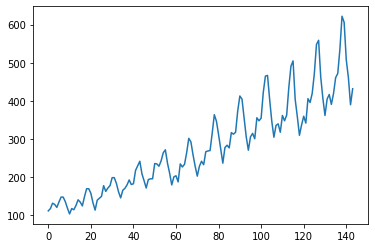

In [ ]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [ ]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [ ]:
def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 30 # 5
look_forward=1

In [ ]:
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

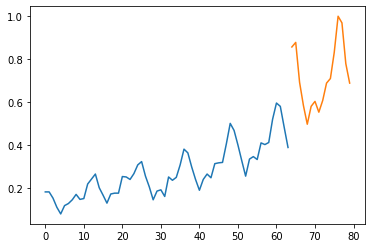

In [ ]:
plt.plot(range(0, len(trainY)), trainY)
plt.plot(range(len(trainY), len(trainY) + len(testY)), testY)

In [ ]:
trainX.shape, testX.shape, trainY.shape, testY.shape

((64, 30), (16, 30), (64, 1), (16, 1))

In [ ]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))

### Train-func

In [2]:
def MAPE(y_pred, y_true):
    loss = (y_pred - y_true).abs() / (y_true.abs() + 1e-8)
    return loss.mean() #loss.mean(axis=0)

In [ ]:
class LSTM_seq(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim) :
        super().__init__()
        self.lstm = LSTM(input_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, 100)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(100, 1)
        
    def forward(self, x):
        hidden = (torch.randn(batch_size, hidden_size),
                    torch.randn(batch_size, hidden_size))
        #hidden = (torch.zeros_like(hidden[0]), torch.zeros_like(hidden[1]))
        #out, hidden = network(X, hidden)
        out, (h_t, c_t) = self.lstm(x, hidden)
        x = self.linear1(h_t)
        x = self.relu1(x)
        x = self.linear2(h_t)
        return x

In [ ]:
def train(network, epochs, learning_rate, train_loader, test_loader=None):
    loss = MAPE
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    
    try:
        for epoch in range(epochs):
            losses = []
            for X, y in train_loader:
                network.zero_grad()
                
                X = X.T
                X = X.reshape(X.shape[0], X.shape[1], 1)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
           
            train_loss_epochs.append(np.mean(losses))
            
            if test_loader is not None:
                losses = []
                with torch.no_grad():
                    for X, y in test_loader:

                        X = X.T
                        X = X.reshape(X.shape[0], X.shape[1], 1)
                        prediction = network(X)
                        loss_batch = loss(prediction, y)
                        losses.append(loss_batch.item())

                    test_loss_epochs.append(np.mean(losses))
            
                #clear_output(True)
                if epoch % 10 == 0:
                    print('\rEpoch {0}... (Train/Test) MAPE: {1:.3f}/{2:.3f}'.format(
                                epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
            else:
                if epoch % 10 == 0:
                    print('\rEpoch {0}... (Train) MAPE: {1:.3f}'.format(
                                epoch, train_loss_epochs[-1]))
        
        if len(train_loss_epochs) > 0:        
            print('Total loss:', train_loss_epochs[-1])
#             plt.figure(figsize=(12, 5))
#             plt.subplot(1, 2, 1)
#             plt.plot(train_loss_epochs, label='Train')
#             plt.plot(test_loss_epochs, label='Test')
#             plt.xlabel('Epochs', fontsize=16)
#             plt.ylabel('Loss', fontsize=16)
#             plt.legend(loc=0, fontsize=16)
#             plt.grid()
#             plt.subplot(1, 2, 2)
#             plt.plot(train_accuracy_epochs, label='Train accuracy')
#             plt.plot(test_accuracy_epochs, label='Test accuracy')
#             plt.xlabel('Epochs', fontsize=16)
#             plt.ylabel('Loss', fontsize=16)
#             plt.legend(loc=0, fontsize=16)
#             plt.grid()
#             plt.show()
    except KeyboardInterrupt:
        pass

In [ ]:
input_size = 1
batch_size = 1
hidden_size = 100
epochs = 50
lr = 0.01

In [ ]:
train_dataloader =  DataLoader(train_dataset, batch_size=batch_size)
test_dataloader =  DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
network = LSTM_seq(input_size, hidden_size) # 
train(network, epochs, lr, train_dataloader) # test_dataloader

Epoch 0... (Train) MAPE: 0.314
Epoch 10... (Train) MAPE: 0.402
Epoch 20... (Train) MAPE: 0.223
Epoch 30... (Train) MAPE: 0.174
Epoch 40... (Train) MAPE: 0.180
Total loss: 0.1611582737241406


#### Предсказание

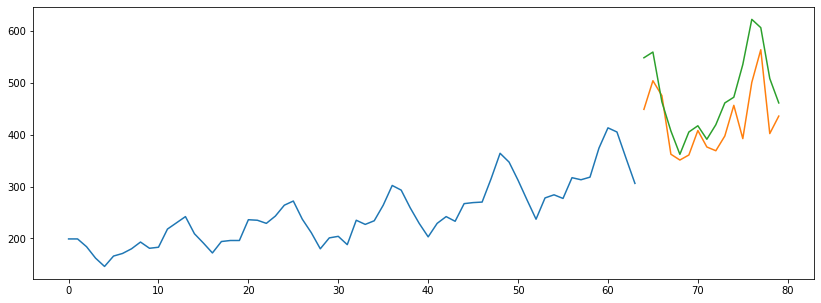

In [ ]:
train_values = []
test_values = []
target_values = []

for _, y in train_dataloader:
    train_values += y.flatten().tolist()

with torch.no_grad():
    for X, y in test_dataloader:
        X = X.T
        X = X.reshape(X.shape[0], X.shape[1], 1)
        test_values += network(X).flatten().tolist()
        target_values += y.flatten().tolist()
        

train_values = scaler.inverse_transform( np.array(train_values).reshape(-1, 1) )
test_values = scaler.inverse_transform( np.array(test_values).reshape(-1, 1) )
target_values = scaler.inverse_transform( np.array(target_values).reshape(-1, 1) )

plt.figure(figsize=(14, 5))
plt.plot(range(len(train_values)), train_values)
plt.plot(range(len(train_values), len(train_values) + len(test_values)), test_values)
plt.plot(range(len(train_values), len(train_values) + len(target_values)), target_values)

## Задание 3 

Поучаствуйте в соревновании https://www.kaggle.com/t/374fc477c4744b009a837153ce135cfb 

Для зачета задания нужно получить значение MAPE меньше 0.2

До 1 мая 2021 можно получить 3,2,1 дополнительных балла за 1, 2 и 3 место соответственно.


Опиционально: сравните классические подходы (ARIMA, gradient boosting trees и RNN)

In [125]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
%matplotlib inline

In [126]:
def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [127]:
def MAPE(y_pred, y_true):
    loss = (y_pred - y_true).abs() / (y_true.abs() + 1e-8)
    return loss.mean() #loss.mean(axis=0)

In [150]:
dataset = pandas.read_csv('train.csv')

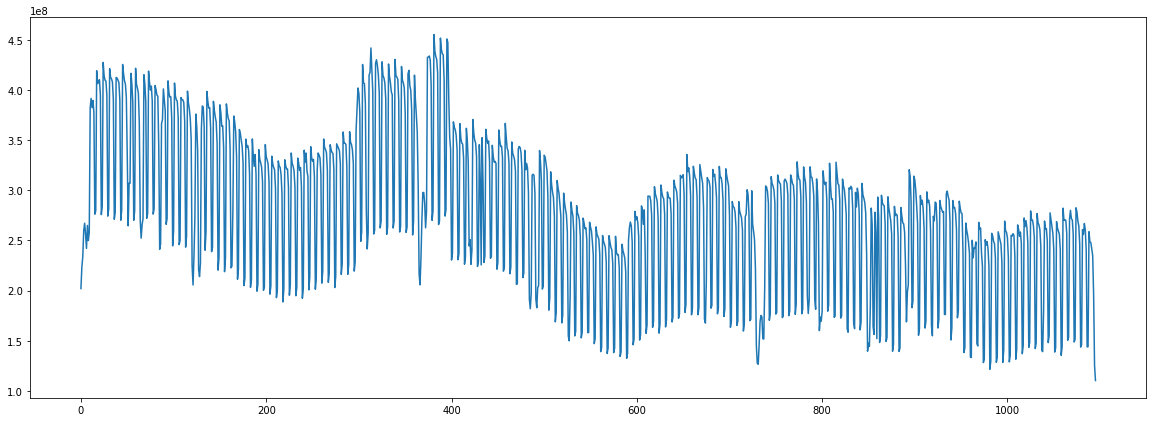

In [151]:
plt.figure(figsize=(20, 7))
plt.plot(range(len(dataset['hits'])), dataset['hits'])
plt.show()

In [152]:
dataset = dataset['hits'].values.reshape(-1, 1) 
dataset = dataset.astype('float32')
mm_scaler = MinMaxScaler(feature_range=(0, 1)) # TODO: standard / (-1;1)
ss_scaler = StandardScaler()

dataset = ss_scaler.fit_transform(dataset)
dataset = mm_scaler.fit_transform(dataset)

part =  0.8 # 0.67
train_size = int(len(dataset) * part)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(len(train), len(test))

876 220


In [153]:
look_back = 180 # 180 # по какому-то периоду, 30 дней например
look_forward=1

input_size = 1
batch_size = 1
hidden_size = 100
epochs = 100
lr = 0.01

In [154]:
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

trainX = trainX.T.reshape(trainX.shape + (1,))
testX = testX.T.reshape(testX.shape + (1,))

train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))

train_dataloader =  DataLoader(train_dataset, batch_size=batch_size)
test_dataloader =  DataLoader(test_dataset, batch_size=batch_size)

In [155]:
trainX.shape

(694, 180, 1)

In [156]:
class LSTM_comp(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.linear1 = nn.Linear(hidden_dim, 1) # мб одного слоя достаточно, либо наоборот усложнить
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.linear2 = nn.Linear(128, 1)
        
    def forward(self, x):
        h_t = torch.randn(batch_size, 1, hidden_size).to(device)
        c_t = torch.randn(batch_size, 1, hidden_size).to(device)
        out, (h_t, c_t) = self.lstm(x, (h_t, c_t))
        h_t = h_t.view(-1, hidden_size)

        # x = self.relu1(h_t)
        x = self.linear1(h_t)
        #x = self.relu2(x)
        #x = self.linear2(x)
        return x

In [157]:
def mape_mse_loss(y_pred, y_true, mape_coef = 0.5):
    loss = MAPE(y_pred, y_true) * mape_coef +  nn.MSELoss()(y_pred, y_true) * (1 - mape_coef)
    return loss

In [163]:
def train(network, epochs, learning_rate, train_loader, test_loader=None, epoch_output=5):
    
    #loss = MAPE
    loss = nn.MSELoss() # TODO: .
    #loss = mape_mse_loss # TODO: 
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_mape_epochs = []
    test_mape_epochs = []
    
    try:
        for epoch in range(epochs):
            losses = []
            mapes = []
            for X, y in train_loader:
                X = X.to(device)
                y = y.to(device)

                network.zero_grad()

                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())

                loss_batch.backward()
                optimizer.step()
                
                with torch.no_grad():
                    mapes.append( MAPE(prediction, y).item() )
                
            train_loss_epochs.append(np.mean(losses))
            train_mape_epochs.append(np.mean(mapes))
            
            if test_loader is not None:
                losses = []
                mapes = []
                with torch.no_grad():
                    for X, y in test_loader:
                        X = X.to(device)
                        y = y.to(device)

                        prediction = network(X)
                        loss_batch = loss(prediction, y)
                        losses.append(loss_batch.item())
                        mapes.append( MAPE(prediction, y).item() )

                    test_loss_epochs.append(np.mean(losses))
                    test_mape_epochs.append(np.mean(mapes))

                if epoch % epoch_output == 0:
                    print('\rEpoch {0}... (Train/Test) Loss: {1:.3f}/{2:.3f}, MAPE: {3:.3f}/{4:.3f}'.format(
                                epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                                train_mape_epochs[-1], test_mape_epochs[-1]))
            else:
                if epoch % epoch_output == 0:
                    print('\rEpoch {0}... (Train) Loss: {1:.3f}, MAPE: {2:.3f}'.format(
                                epoch, train_loss_epochs[-1], train_mape_epochs[-1]))
        
        if len(train_loss_epochs) > 0:    
            print('Total loss: {} for {} epochs'.format( train_loss_epochs[-1], epochs) )

    except KeyboardInterrupt:
        pass

In [164]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

network = LSTM_comp(input_size, hidden_size)
network = network.to(device)

In [ ]:
train(network, epochs, lr, train_dataloader, test_dataloader)

Epoch 0... (Train/Test) Loss: 0.028/0.039, MAPE: 0.409/0.851
Epoch 5... (Train/Test) Loss: 0.010/0.034, MAPE: 0.199/0.748
Epoch 10... (Train/Test) Loss: 0.010/0.035, MAPE: 0.191/0.789
Epoch 15... (Train/Test) Loss: 0.011/0.035, MAPE: 0.230/0.744
Epoch 20... (Train/Test) Loss: 0.010/0.039, MAPE: 0.201/0.756
Epoch 25... (Train/Test) Loss: 0.010/0.038, MAPE: 0.198/0.753
Epoch 30... (Train/Test) Loss: 0.010/0.037, MAPE: 0.195/0.758
Epoch 35... (Train/Test) Loss: 0.012/0.038, MAPE: 0.223/0.814


#### Plot

In [161]:
def plot_prediction(train_dataloader, test_dataloader):
    train_values = []
    test_values = []
    target_values = []

    for _, y in train_dataloader:
        train_values += y.flatten().tolist()

    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            #X = X.T
            #X = X.reshape(X.shape[0], X.shape[1], 1)
            test_values += network(X).flatten().tolist()
            target_values += y.flatten().tolist()


    train_values = scaler.inverse_transform( np.array(train_values).reshape(-1, 1) )
    test_values = scaler.inverse_transform( np.array(test_values).reshape(-1, 1) )
    target_values = scaler.inverse_transform( np.array(target_values).reshape(-1, 1) )

    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_values)), train_values)
    plt.plot(range(len(train_values), len(train_values) + len(test_values)), test_values)
    plt.plot(range(len(train_values), len(train_values) + len(target_values)), target_values)
    
    #train_values = scaler.inverse_transform( np.array(train_values).reshape(-1, 1) )
    #return train_values, test_values, target_values

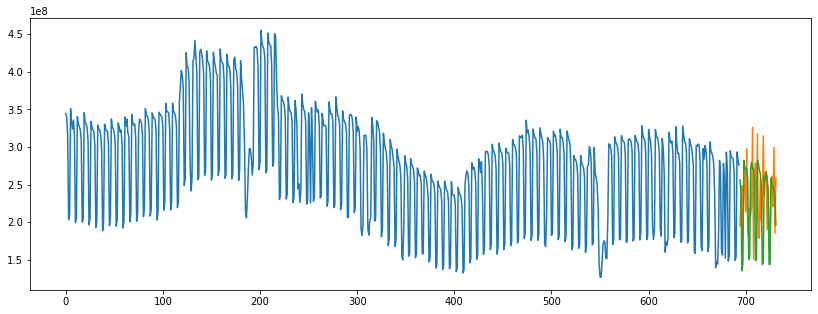

In [162]:
plot_prediction(train_dataloader, test_dataloader)

#### Predict

In [18]:
dataset[:10]

array([[0.26579288],
       [0.327049  ],
       [0.3580781 ],
       [0.43319115],
       [0.45473996],
       [0.4229512 ],
       [0.38187727],
       [0.44815347],
       [0.40451732],
       [0.42813364]], dtype=float32)

mem


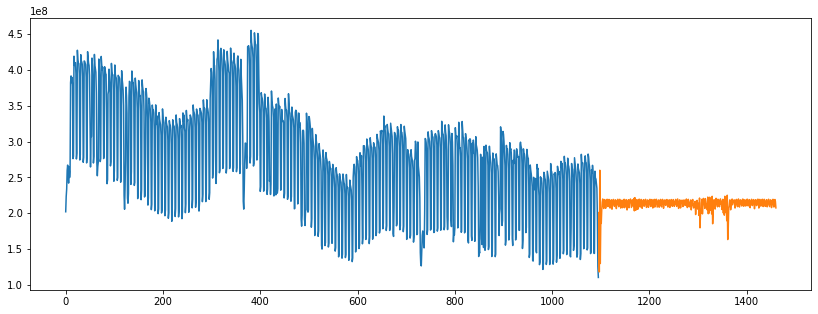

In [20]:
train_values = dataset.copy()

y_pred = dataset[-look_back:].flatten().tolist()
label_count = 365

with torch.no_grad():
    for i in range(label_count):
        X = np.array(y_pred[i:]).reshape(1, -1, 1)
        X = torch.tensor(X, dtype=torch.float32).to(device)
        
        #test_values = torch.tensor( network(X).item() ).to(device) #torch.tensor( network(X).flatten().tolist()[0] )
        y_pred.append( network(X).flatten().tolist()[0] )

print('mem')

y_pred = np.array(y_pred)
test_values = ss_scaler.inverse_transform( mm_scaler.inverse_transform( y_pred.reshape(-1, 1) ) )
train_values = ss_scaler.inverse_transform( mm_scaler.inverse_transform( train_values ) )

plt.figure(figsize=(14, 5))
plt.plot(range(len(train_values)), train_values)
plt.plot( range(len(train_values), len(train_values) + len(test_values[look_back:])), test_values[look_back:] )

#plt.plot(range(len(train_values), len(train_values) + len(test_values)), test_values)
#plt.plot(range(len(train_values), len(train_values) + len(target_values)), target_values)

Что пробовал:
- LSTM
- BiLSTM
- GRU
- разные длины входной последовательности
- генерация одного элемента в качестве выхода
- генерация большого количества элементов в качестве выхода(разные комбинации)
- тюнинг гиперпараметров